# Multi-objective robust decision making (MORDM)


This exercise demostrates the application of MORDM on the lake model, which was used in earlier exercises.

MORDM has four main steps:

(i)	    **problem formulation** based on a systems analytical problem definition framework 

(ii)	**searching** for candidate solutions that optimize multiple objectives by using multi-objective evolutionary algorithms 

(iii)	generating an ensemble of scenarios to **explore** the effects of uncertainties 

(iv)	using **scenario discovery** to detect the vulnerabilities of candidate solutions and improving thecandidate solutions



## Step 1: Problem formulation
### Lake Model

Remember the lake problem used in the assignments in previous weeks. The lake problem is a hypothetical case where the inhabitants of a lake town decide on the amount of annual pollution they release into a lake. It the pollution in the lake passes a threshold, it will suffer irreversible eutrophication.

The lake problem has 4 **outcome indicators**: 
   - **max_P**: maximum pollution over time, to be minimized
   - **utility**: economic benefits obtained from polluting the lake, to be maximized
   - **inertia**: the percentage of significant annual changes in the anthropogenic pollution rate, to be maximized
   - **reliability**: the percentage of years where the pollution level is below the critical threshold, to be maximized
    
See the lake mode exercise for the formulation of these outcome variables.

The lake problem is characterized by both stochastic uncertainty and **deep uncertainty**. The stochastic uncertainty arises from the natural inflow. To reduce this stochastic uncertainty, multiple replications are performed and the average over the replication is taken. Deep uncertainty is presented by uncertainty about the mean $\mu$ and standard deviation $sigma$ of the lognormal distribution characterizing the natural inflow, the natural removal rate of the lake $\beta$, the natural recycling rate of the lake $q$, and the discount rate $\delta$. The table below specifies the ranges for the deeply uncertain factors, as well as their best estimate or default values. 

|Parameter	|Range	        |Default value|
|-----------|--------------:|------------:|
|$\mu$    	|0.01 – 0.05	|0.02         |
|$\sigma$	|0.001 – 0.005 	|0.0017       |
|$b$      	|0.1 – 0.45	    |0.42         |
|$q$	    |2 – 4.5	    |2            |
|$\delta$	|0.93 – 0.99	|0.98         |


The lake problem in previous assignments had 100 decision **levers**, meaning that the decision makers independently decide on the amount of anthropogenic pollution at every time step (100). Then a 'policy' was a set of values for these 100 levers, which you composed by sampling from the range [0, 0.1].   

In this exercise, we will use a more advanced way of deciding on the amout of anhtropogenic polution. We will use a **closed loop** version of the lake model, meaning that $a_t$ (anthropogenic pollution) is dependent on $X_t$ (the pollution level at time t). For instance, the rate of anthropogenic pollutions is lowered if the pollution level is approaching a critical threshold. Here, we use "cubic radial basis functions" following [Quinn et al. 2017](http://www.sciencedirect.com/science/article/pii/S1364815216302250) and formulate $a_t$ as follows:

\begin{equation}
    a_{t} =  min\Bigg(max\bigg(\sum\limits_{j=1}^{n} w_{j}\left\vert{\frac{X_{t,i}-c_{j}}{r_{j}}}\right\vert^3, 0.01\bigg), 0.1\Bigg) \\
    s.t. \\
    -2 \leq c_{j} \leq 2 \\
    0 \leq r_{j} \leq 2 \\ 
    0 \leq w_{j} \leq 1 \\
    \sum\limits_{j=1}^{n} w_{j} = 1
\end{equation}


The parameters that define this function also define the pollution strategy over time. Hence, the decision **levers** are the five parameters of this functions, namely $c_1$, $c_2$, $r_1$, $r_2$ and $w_1$. ($w_2$ = 1 - $w_1$).

Note:: i is index for the realization, given m realizations; j is the index for the radial basis function, given 2 radial basis functions. 

**To formulate this problem, do the following:**

**1) Define a function for the anthropogenic pollution given values for $c_1$, $c_2$, $r_1$, $r_2$, $w_1$, and $X_t$**

**2) adapt the lake model function, which is the 'system model' for this problem, from the previous assignments to use this new decision rule.**

*hint*: in this formulation the decision is specified by a decision rule. You specify the decision rule using the radial basis functions. An example of such a rule is shown in figure 2 in Quinn et al (2017). Since you are making the **actual release decision** in a given year **conditional on the observed pollution** in the lake in the previous year, your actual release will differ from one stochastic realization to the next. This means that you have to ensure that you adapt the inertia objective accordingly! 

**3) Create an ema_workbench interface for this problem, with corresponding uncertainties, levers and outcomes.**


try to work it out yourself first. If you struggle, have a look [here](https://waterprogramming.wordpress.com/author/jhkwakkel/)


In [1]:
from lakemodel_function import lake_model, make_df

In [2]:
lake_model()

(0.12258207614605623,
 0.35525353120039244,
 0.9900000000000014,
 1.0000000000000007)

In [45]:
import ast
import time
import math

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench import (perform_experiments, Model, RealParameter, ScalarOutcome,
                           Policy, Scenario, Constant,
                           ema_logging, MultiprocessingEvaluator)

from ema_workbench.em_framework.evaluators import MC

from ema_workbench.analysis import parcoords

ema_logging.log_to_stderr(ema_logging.INFO)

C:\Anaconda3\envs\py36_32\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
C:\Anaconda3\envs\py36_32\lib\importlib\_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)


<Logger EMA (DEBUG)>

In [13]:
model = Model('lakeproblem', function=lake_model)

# Set reference Scenario
reference_values = {'b': 0.42,
                    'q': 2.0,
                    'mean': 0.02,
                    'stdev': 0.0017,
                    'delta': 0.98}
ref_scenario = Scenario("reference", **reference_values)

# set levers
model.levers = [RealParameter("c1", -2, 2),
                RealParameter("c2", -2, 2),
                RealParameter("r1", 0, 2),
                RealParameter("r2", 0, 2),
                RealParameter("w1", 0, 1)]

#specify outcomes
model.outcomes = [ScalarOutcome('max_P',ScalarOutcome.MINIMIZE),
                  ScalarOutcome('utility',ScalarOutcome.MAXIMIZE),
                  ScalarOutcome('inertia',ScalarOutcome.MAXIMIZE),
                  ScalarOutcome('reliability',ScalarOutcome.MAXIMIZE)]

outcomes = "max_P	utility	inertia	reliability".split("	")

## Step 2: Searching for candidate solutions

In the second step of MORDM, candidate strategies are identified which are pareto optimal conditional on a reference scenario. These candiate strategies are identified through search with multi-objective evolutionary algorithms, that iteratively evaluate a large number of alternatives on multiple objectives until they find the best candidates. For instance, when we optimize the lake model levers, the lake model function will be called for each candidate evaluation, and the corresponding four objective values will be generated. 

*Platypus* is python package developed by David Hadka (http://platypus.readthedocs.io/en/latest/) for multi-objective optimization. It allows an explicit specification of the problem components (levers, objectives, constraints). The package includes several multi-objective evolutionary algorithms, therefore the users can choose the algorithm they wish to use. 

you can use pip to install it:

```
pip install git+https://github.com/Project-Platypus/Platypus.git

```

In this exercise, I recommend to use Platypus with the ε-NSGAII algorithm, since it is shown to outperform many MOEA’s. For other algortihms, see the documentation of Platypus. For a comparison of them, you can have a look at [Reed et al (2013)](http://dx.doi.org/10.1016/j.advwatres.2012.01.005).
    
    
Take the model interface deveoped in the previous step and use the optimization functionality of the workbench to identify the pareto approximate set of solutions. Try the following:

### 1) change the epsilon values between 0.01 and 0.1, what changes, why?

**ANSWER → smaller value of epsilon gives more solutions, as the space are divided even finer.**

    0.1: 10~12 solutions
    0.05: 19~20 solutions
    0.01: 60+ solutions

#### epsilon = 0.1

In [14]:
start = time.time()
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.optimize(nfe=100, searchover='levers', reference = ref_scenario,
                                 epsilons=[0.1,]*len(model.outcomes))
end = time.time()
print(end - start)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/100 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] optimization completed, found 6 solutions
[MainProcess/INFO] terminating pool


8.130423545837402


In [9]:
results

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
0,-0.156920,0.307817,1.233928,0.319979,0.103514,0.213432,0.542640,0.9900,1.0000
1,0.236399,1.716633,0.908166,1.814781,0.938883,2.283738,1.048124,0.9758,0.3747
2,0.512761,0.643369,0.155698,1.682863,0.168497,2.283946,1.476050,0.9742,0.1194
3,1.390187,-0.013717,1.404929,0.539909,0.667491,2.283763,1.734761,0.9900,0.0700
4,0.122058,0.510817,1.621870,1.806967,0.045178,0.097754,0.243403,0.9900,1.0000
5,-0.059961,0.544502,0.702567,1.236181,0.749792,2.283992,1.261293,0.9796,0.2386


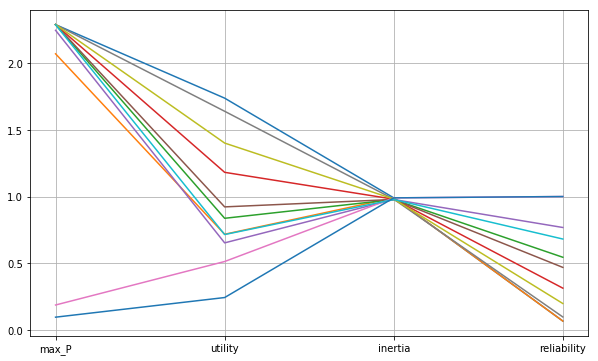

In [24]:
plt.figure(figsize=(10,6))
for items in results[outcomes].T.iteritems():
    row, values = items
    plt.plot(values)
plt.grid()

#### epsilon = 0.05

In [26]:
start = time.time()
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.optimize(nfe=1000, searchover='levers',
                                 epsilons=[0.05,]*len(model.outcomes))
end = time.time()
print(end - start)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/1000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 1: 100/1000 nfe
[MainProcess/INFO] performing 1 scenarios * 99 policies * 1 model(s) = 99 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 2: 199/1000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 3: 299/1000 nfe
[MainProcess/INFO] performing 1 scenarios * 99 policies * 1 mo

40.18388295173645


In [27]:
results

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
0,0.576675,0.098287,0.043963,0.096613,0.344633,2.283657,1.734761,0.9900,0.0700
1,0.149268,0.614900,1.209194,0.935209,0.597718,0.239639,0.552260,0.9900,1.0000
2,0.761140,1.911258,1.207586,1.446740,0.014623,1.981661,0.631921,0.9900,0.0700
3,-0.386661,-0.534416,1.962356,0.957046,0.991877,2.283845,0.728386,0.9863,0.5697
4,0.476763,-0.772434,1.128013,1.333316,0.956194,2.255768,0.650779,0.9785,0.7776
5,0.793286,0.259250,1.995556,0.735326,0.042948,0.098847,0.258773,0.9900,1.0000
6,1.410259,0.344838,0.698070,0.653418,0.002689,0.198224,0.523513,0.9900,1.0000
7,0.759329,0.047952,1.496824,0.969495,0.937965,2.283906,0.776228,0.9728,0.5057
8,1.781067,0.259250,1.720219,0.331864,0.055529,2.283842,1.516039,0.9789,0.1502
9,0.761140,1.851139,1.037146,1.353654,0.014623,2.037554,0.780324,0.9900,0.0700


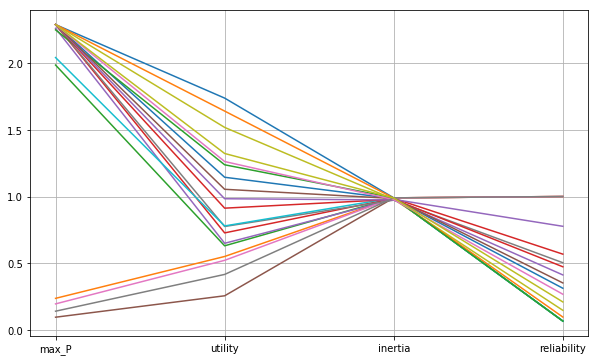

In [28]:
plt.figure(figsize=(10,6))
for items in results[outcomes].T.iteritems():
    row, values = items
    plt.plot(values)
# plt.legend()
plt.grid()

#### epsilon = 0.01

In [29]:
start = time.time()
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.optimize(nfe=1000, searchover='levers',
                                 epsilons=[0.01,]*len(model.outcomes))
end = time.time()
print(end - start)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/1000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 1: 100/1000 nfe
[MainProcess/INFO] performing 1 scenarios * 99 policies * 1 model(s) = 99 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 2: 199/1000 nfe
[MainProcess/INFO] performing 1 scenarios * 98 policies * 1 model(s) = 98 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 3: 297/1000 nfe
[MainProcess/INFO] performing 1 scenarios * 99 policies * 1 model(s) = 99 experiments
[MainProcess/INF

40.67393112182617


In [30]:
results

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
0,-0.479616,-1.177583,1.189927,1.792505,0.460159,2.283677,1.734761,0.9900,0.0700
1,-0.202684,1.115757,1.686596,1.974406,0.500668,2.283719,1.503350,0.9835,0.1400
2,0.268332,-0.741559,0.632222,1.589078,0.984544,0.118033,0.335749,0.9900,1.0000
3,0.706867,0.406121,1.332476,0.115889,0.353058,1.921902,1.137033,0.9777,0.3649
4,0.346599,0.120892,0.541304,0.369186,0.616786,0.167931,0.475017,0.9900,1.0000
5,-0.513087,0.854541,1.874943,1.700960,0.706768,2.283835,1.584164,0.9900,0.1200
6,0.375016,0.120892,0.541304,0.356260,0.682349,0.203622,0.530799,0.9900,1.0000
7,0.263067,1.182732,1.020014,1.648529,0.832739,2.283559,0.716224,0.9744,0.6508
8,0.375180,0.120892,0.469442,0.356260,0.602983,2.283746,1.325342,0.9765,0.2402
9,0.706867,0.406121,1.332476,0.115889,0.322520,2.036270,1.214611,0.9772,0.3105


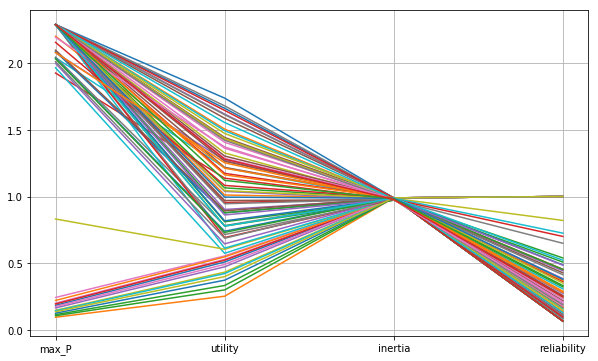

In [31]:
plt.figure(figsize=(10,6))
for items in results[outcomes].T.iteritems():
    row, values = items
    plt.plot(values)
# plt.legend()
plt.grid()

### 2) change the number of function evaluations from 1000 to 10.000 (this requires using multiprocessing unless you are very patient). What is the difference?
You can use the convergence as explained in the water programming tutorial to answer this question.

**Answer → Solutions (Alternatives) are not so polarized. But why? **

#### nfe = 3000

In [32]:
start = time.time()
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.optimize(nfe=3000, searchover='levers',
                                 epsilons=[0.1,]*len(model.outcomes))
end = time.time()
print(end - start)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/3000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 1: 100/3000 nfe
[MainProcess/INFO] performing 1 scenarios * 99 policies * 1 model(s) = 99 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 2: 199/3000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 3: 299/3000 nfe
[MainProcess/INFO] performing 1 scenarios * 98 policies * 1 mo

[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 30: 2970/3000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] optimization completed, found 13 solutions
[MainProcess/INFO] terminating pool


114.49450302124023


In [33]:
results

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
0,-0.469668,0.962474,1.793400,1.699985,0.657207,2.283806,1.645723,0.9900,0.1000
1,0.258646,0.292980,0.858523,0.843688,0.240326,0.096545,0.247668,0.9900,1.0000
2,0.565100,1.931556,1.908834,1.610874,0.112117,2.194359,1.240704,0.9900,0.0700
3,0.132648,0.736082,0.610918,1.026223,0.732693,2.283813,1.362001,0.9785,0.2181
4,0.472853,0.496417,0.370996,1.112376,0.011105,0.192300,0.514234,0.9900,1.0000
5,0.615320,0.009167,0.808839,1.144198,0.226098,2.283279,0.748893,0.9773,0.6678
6,0.883606,1.995607,1.576181,1.399150,0.093250,2.078236,0.925472,0.9900,0.0700
7,1.755330,1.994622,1.915456,0.872761,0.181891,1.961198,0.619234,0.9900,0.0700
8,0.132648,0.709437,0.820327,1.026223,0.687394,2.283585,0.876037,0.9760,0.5279
9,-0.293128,-0.058275,0.519532,1.655285,0.990360,2.283609,1.734761,0.9900,0.0700


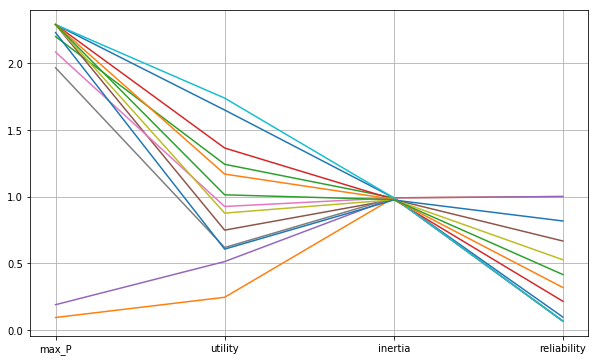

In [34]:
plt.figure(figsize=(10,6))
for items in results[outcomes].T.iteritems():
    row, values = items
    plt.plot(values)
# plt.legend()
plt.grid()

#### nfe = 5000

In [35]:
start = time.time()
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.optimize(nfe=5000, searchover='levers',
                                 epsilons=[0.1,]*len(model.outcomes))
end = time.time()
print(end - start)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/5000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 1: 100/5000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 2: 200/5000 nfe
[MainProcess/INFO] performing 1 scenarios * 98 policies * 1 model(s) = 98 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 3: 298/5000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess

[MainProcess/INFO] generation 29: 2880/5000 nfe
[MainProcess/INFO] performing 1 scenarios * 97 policies * 1 model(s) = 97 experiments
[MainProcess/INFO] 32 cases completed
[MainProcess/INFO] 64 cases completed
[MainProcess/INFO] 96 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 30: 2977/5000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 31: 3077/5000 nfe
[MainProcess/INFO] performing 1 scenarios * 97 policies * 1 model(s) = 97 experiments
[MainProcess/INFO] 32 cases completed
[MainProcess/INFO] 64 cases completed
[MainProcess/INFO] 96 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 32: 3174/5000 nfe
[MainProcess/INFO] performing 1 scenarios * 98 policies * 1 model(s) = 98 experiments


187.4574956893921


In [36]:
results

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
0,-0.730927,1.854507,1.360431,1.761940,0.934307,2.283642,1.734761,0.9900,0.0700
1,1.168651,1.974053,1.523181,1.482861,0.221934,2.147441,1.046720,0.9900,0.0700
2,0.274432,-0.561252,0.561247,0.967823,0.934293,2.283758,1.383082,0.9813,0.2066
3,0.148377,0.879210,0.533007,1.605265,0.569194,2.283779,1.142624,0.9779,0.3351
4,0.148377,0.885854,0.497740,1.676965,0.587443,2.271586,0.721721,0.9774,0.7053
5,0.302463,0.760176,0.569943,0.984861,0.898298,0.195165,0.519695,0.9900,1.0000
6,-0.241858,0.826974,1.229097,1.448698,0.577762,2.283823,1.643011,0.9900,0.1000
7,0.148377,0.888667,0.497740,1.676965,0.587443,2.283685,0.810260,0.9774,0.6005
8,0.208154,0.517175,0.487631,1.937463,0.591962,0.096763,0.252387,0.9900,1.0000
9,0.116611,0.862212,0.497740,1.676965,0.587443,2.283832,1.006161,0.9783,0.4206


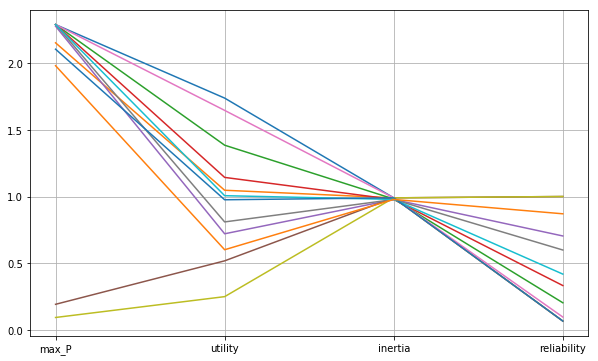

In [37]:
plt.figure(figsize=(10,6))
for items in results[outcomes].T.iteritems():
    row, values = items
    plt.plot(values)
# plt.legend()
plt.grid()

#### nfe = 10000

In [5]:
start = time.time()
with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.optimize(nfe=10000, searchover='levers',
                                 epsilons=[0.1,]*len(model.outcomes))
end = time.time()
print(end - start)

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 1: 100/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 98 policies * 1 model(s) = 98 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 2: 198/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 3: 298/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 99 policies * 1 model(s) = 99 experiments
[MainProce

[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 29: 2870/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 30: 2970/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 31: 3070/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 98 policies * 1 model(s) = 98 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 32: 3168/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 ex

[MainProcess/INFO] 64 cases completed
[MainProcess/INFO] 96 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 58: 5735/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 97 policies * 1 model(s) = 97 experiments
[MainProcess/INFO] 32 cases completed
[MainProcess/INFO] 64 cases completed
[MainProcess/INFO] 96 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 59: 5832/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 99 policies * 1 model(s) = 99 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 60: 5931/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 98 policies * 1 model(s) = 98 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 61: 6029/10000 nfe
[MainP

[MainProcess/INFO] 32 cases completed
[MainProcess/INFO] 64 cases completed
[MainProcess/INFO] 96 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 87: 8598/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 98 policies * 1 model(s) = 98 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 88: 8696/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 100 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] 33 cases completed
[MainProcess/INFO] 66 cases completed
[MainProcess/INFO] 99 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] generation 89: 8796/10000 nfe
[MainProcess/INFO] performing 1 scenarios * 97 policies * 1 model(s) = 97 experiments
[MainProcess/INFO] 32 cases completed
[MainProcess/INFO] 64 cases completed
[MainProcess/INFO] 96 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/IN

[MainProcess/INFO] [Solution[0.3099366899398493,-0.07787551063612885,0.06743728291100477,1.288353044813916,0.7530453083426095|1.9458143696973786,1.5159884799150325,0.9423000000000009,0.23060000000000033|0], Solution[0.26957454026458805,-0.3002658521119239,0.06604141568347148,1.317542626310773,0.758473035652425|0.3569295883695725,0.6106130753815293,0.9892000000000014,0.9555000000000007|0]]
[MainProcess/INFO] [Solution[0.25745927838487803,-0.31187053933914005,0.08115142609737107,1.6257208025822443,0.7380355640328816|1.2802724543306738,1.118763491143043,0.9641000000000003,0.5373000000000006|0], Solution[0.26957454026458805,-0.3010076382520126,0.06502948468153746,1.3188144346144808,0.7457717515008029|0.5604700582764889,0.713552672339175,0.9883000000000011,0.8674000000000005|0]]
[MainProcess/INFO] [Solution[0.28500908093780625,0.6083859986664182,0.34277122336428967,1.3140654403140766,0.5043177549609583|0.1938380349774995,0.5203164813969061,0.9900000000000014,1.0000000000000007|0], Solution[

371.9990129470825


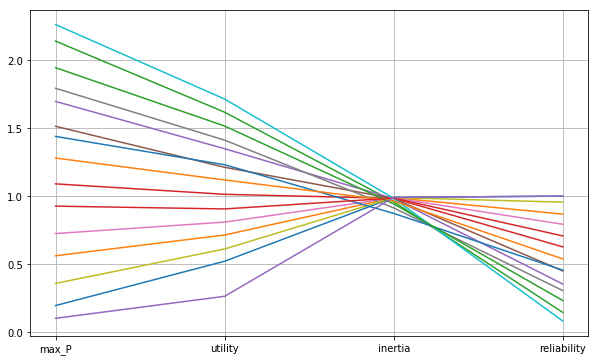

In [6]:
plt.figure(figsize=(10,6))
for items in results[outcomes].T.iteritems():
    row, values = items
    plt.plot(values)
plt.grid()

**plot the tradeoffs you have found using a parallel axis plot**

We can visualize these tradeoffs on **parallel axis plots**. In these plots, each dimension is shown as a vertical axis. Each solution is represented by a line on this plot, which crosses the objective axes at the corresponsing value. You can use the [parcoords functionality](https://emaworkbench.readthedocs.io/en/latest/ema_documentation/analysis/parcoords.html) for this that comes with the ema_workbench. Ensure that the direction of desirability is the same for the four objectives.

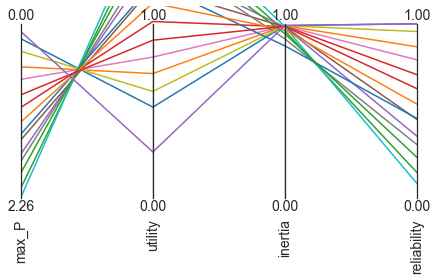

In [9]:
data = results.loc[:, [o.name for o in model.outcomes]]
limits = parcoords.get_limits(data)
limits.loc[0, ['utility', 'inertia', 'reliability', 'max_P']] = 0
limits.loc[1, ['utility', 'inertia', 'reliability']] = 1

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis('max_P')

**What does this plot tell us about the tradeoffs and conflicting objectives?**


**Answer**

1. <code>max_P</code> and <code>reliability</code> has a same destiny. → i.e. the low <code>max_P</code> and the high <code>reliability</code> are highly coupled.

2. <code>max_P</code> + <code>reliability</code> and <code>utility</code> are conflicting → i.e. it is hard to achieve the low <code>max_P</code> + the high <code>reliability</code> and the high <code>utility</code> at the same time

3. <code>inertia</code> has no conflict with other objectives

In [11]:
results

,c1,c2,r1,r2,w1,max_P,utility,inertia,reliability
0,0.285009,0.608386,0.342771,1.314065,0.504318,0.193838,0.520316,0.9900,1.0000
1,0.269575,-0.301008,0.065029,1.318814,0.745772,0.560470,0.713553,0.9883,0.8674
2,0.257444,-0.293061,0.065648,1.722639,0.736212,2.141184,1.617821,0.9585,0.1431
3,0.269575,-0.301008,0.044660,1.456512,0.690851,1.090118,1.013202,0.9833,0.6261
4,0.269575,-0.300942,0.044036,1.346579,0.726743,1.697241,1.348932,0.9808,0.3522
5,0.269950,-0.301008,0.069220,1.261531,0.749670,1.514044,1.212092,0.9816,0.4489
6,0.269294,-0.293760,0.054003,1.254799,0.797263,0.724187,0.808520,0.9867,0.7923
7,0.256789,-0.255679,0.073931,1.455500,0.851758,1.793996,1.412135,0.9128,0.3040
8,0.269575,-0.300266,0.066041,1.317543,0.758473,0.356930,0.610613,0.9892,0.9555
9,0.242179,-0.292959,0.074806,1.821507,0.738036,2.263280,1.714549,0.9830,0.0797


In [ ]:
new_results = results[results["reliability"] > 0.9]
new_results.to_csv("new_results.csv")
new_results

## Step 3: Re-evaluate candidate solutions under uncertainty

We now have a large number of candidate solutions (policies), we can re-evaluate them over the various deeply uncertaint factors to assess their robustness against uncertainties.

For this robustness evaluation, we need to explore the scenarios for each solution. It means that, if we would like to run for instance 1000 scenarios for each solution, we might have to execute a very large number of runs.

Here, to simplify the case, let's suppose that decision makers have a hard constrain on *reliability*. No solution with less than 90% reliability is acceptable for them. Therefore, we can reduce the size of the solution set according to this constraint. 

**Apply this constraint of reliability on the results, and create a new dataframe named new_reults**


In [1]:
from lakemodel_function import *

In [11]:
import ast
import time
import math
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from ema_workbench import (perform_experiments, Model, RealParameter, ScalarOutcome, Policy,
                           Constant, ema_logging, MultiprocessingEvaluator)
from ema_workbench.em_framework.evaluators import MC

ema_logging.log_to_stderr(ema_logging.INFO)

model = Model('lakeproblem', function=lake_model)

model.uncertainties = [RealParameter('b', 0.1, 0.45),
                            RealParameter('q', 2.0, 4.5),
                            RealParameter('mean', 0.01, 0.05),
                            RealParameter('stdev', 0.001, 0.005),
                            RealParameter('delta', 0.93, 0.99)]

model.levers = [RealParameter("c1", -2, 2),
                RealParameter("c2", -2, 2),
                RealParameter("r1", 0, 2),
                RealParameter("r2", 0, 2),
                RealParameter("w1", 0, 1)]

model.outcomes = [ScalarOutcome('max_P',),
                       ScalarOutcome('utility'),
                       ScalarOutcome('inertia'),
                       ScalarOutcome('reliability')]

write the new_results to a csv file. You will need them to complete the MORO assignment.


**From new_results, which is the reduced dataframe of candidate solutions, make a list of policies in a fromat that can be inputed to the *perform_experiments* function of the EMA workbench.**

*hint: you need to transform each policy to a dict, and then use this dict as input for the Policy class that comes with the workbench*

In [8]:
new_results = pd.read_csv("new_results.csv", index_col=0)
new_results.iloc[:, :5].T.to_dict()

{0: {'c1': 0.28500908093780625,
  'c2': 0.6083859986664182,
  'r1': 0.3427712233642897,
  'r2': 1.3140654403140766,
  'w1': 0.5043177549609583},
 8: {'c1': 0.26957454026458805,
  'c2': -0.3002658521119239,
  'r1': 0.06604141568347148,
  'r2': 1.3175426263107728,
  'w1': 0.758473035652425},
 14: {'c1': 0.28337396238371426,
  'c2': 0.3336481682032525,
  'r1': 0.6828066816716089,
  'r2': 1.7288240808006012,
  'w1': 0.5601669031817604}}

In [9]:
# Create a list of Policy objects
policies = []
for pol, dic in new_results.iloc[:, :5].T.to_dict().items():
    policies.append(Policy(pol, **dic))
policies

[{'c1': 0.28500908093780625, 'c2': 0.6083859986664182, 'r1': 0.3427712233642897, 'r2': 1.3140654403140766, 'w1': 0.5043177549609583},
 {'c1': 0.26957454026458805, 'c2': -0.3002658521119239, 'r1': 0.06604141568347148, 'r2': 1.3175426263107728, 'w1': 0.758473035652425},
 {'c1': 0.28337396238371426, 'c2': 0.3336481682032525, 'r1': 0.6828066816716089, 'r2': 1.7288240808006012, 'w1': 0.5601669031817604}]

**Perform 1000 scenarios for each of the policy options. Depending on how many solutions are left after implementing the constraint, consider using multiprocessing or ipyparallel to speed up calculations.**

If you want to use ipyprallel, don't forget to start ipcluster.

In [13]:
n_scenarios = 1000

start = time.time()
with MultiprocessingEvaluator(model) as evaluator:
        results = evaluator.perform_experiments(scenarios=n_scenarios, policies=policies)
end = time.time()
print(end - start)

[MainProcess/INFO] pool started
[MainProcess/INFO] performing 1000 scenarios * 3 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


103.17831802368164


In [14]:
inputs = pd.DataFrame(results[0])
outcomes = pd.DataFrame(results[1])

In [15]:
# failure if reliability is less than 90%
fail = outcomes["reliability"].apply(lambda x: 0 if x > 0.9 else "fail")

In [16]:
inputs["fail"] = fail.values

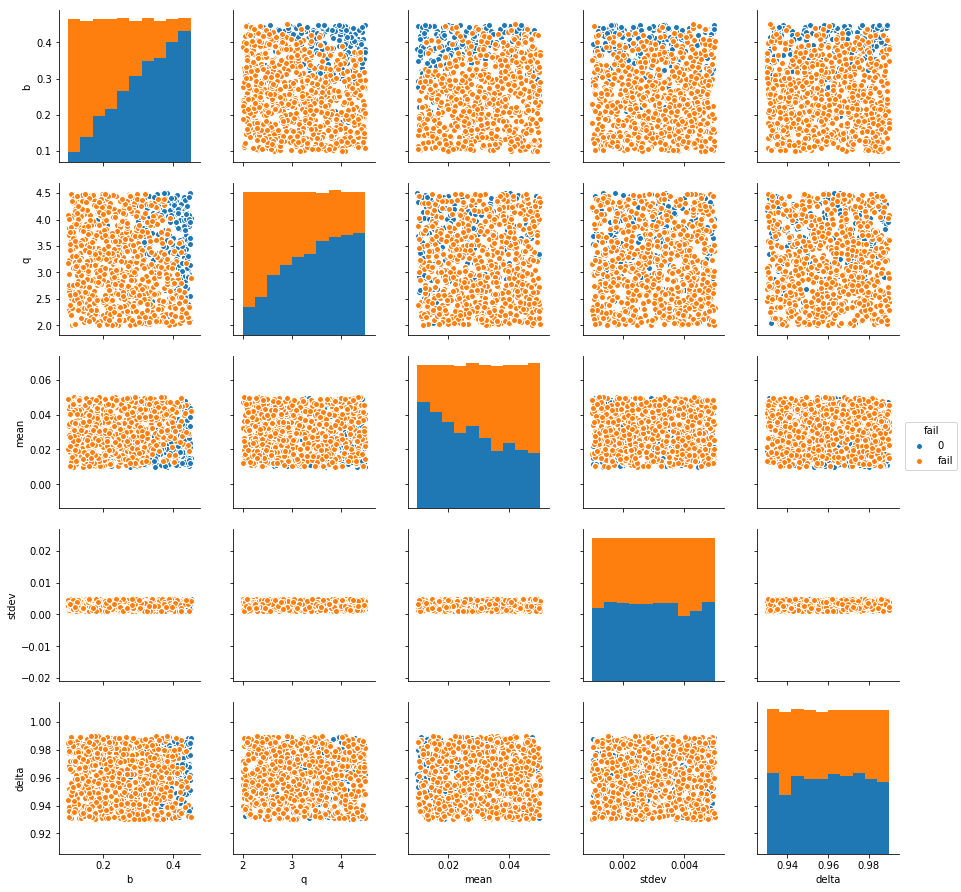

In [17]:
sns.pairplot(inputs, vars=model.uncertainties.keys(), hue="fail")

Text(0.5,1.02,'How Policy can fail/success under varying Uncertainties')

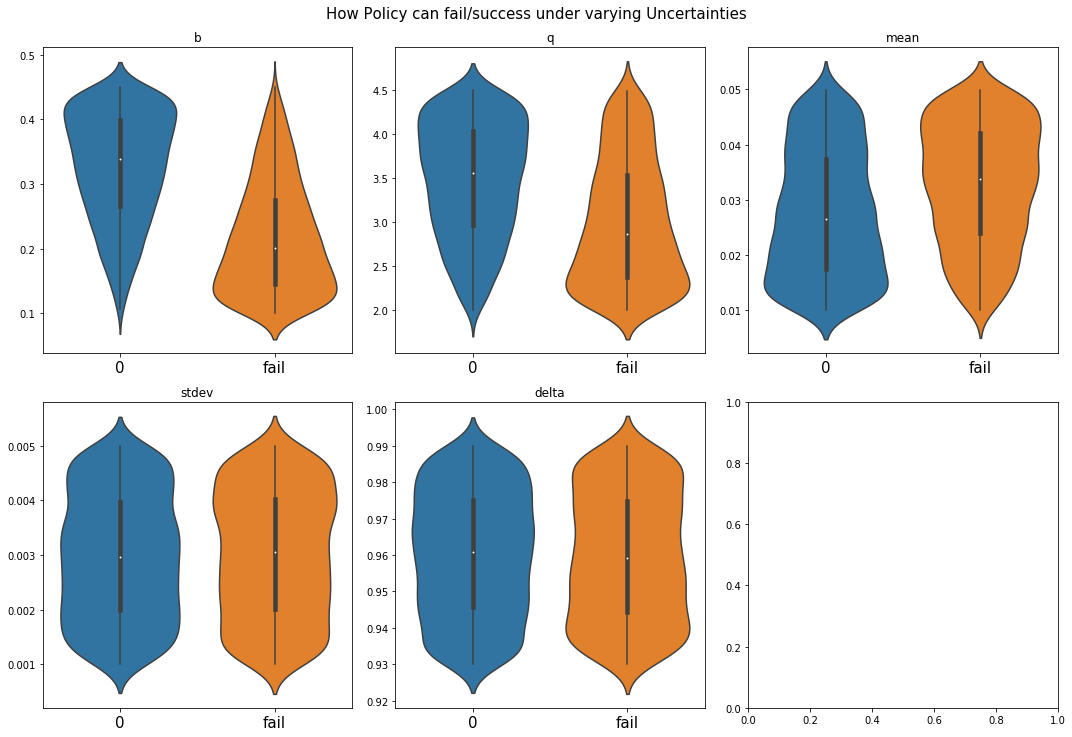

In [18]:
import itertools

ncols=3
nrows=2
fig, axes = plt.subplots(ncols = ncols, nrows = nrows,
#                          sharex = True,
                         figsize = (5*ncols,5*nrows))
locs = list(itertools.product(range(nrows),range(ncols)))

params = list(model.uncertainties.keys())

for i,param in enumerate(params):
    loc=locs[i]
    ax=axes[loc]
    sns.violinplot("fail", param, data = inputs, ax=ax, legend=True,
#                    hue="policy"
                  )
    ax.set_xlabel("")
    ax.set_xticklabels(inputs["fail"].unique(),fontsize=15)
    ax.set_ylabel("")
    ax.set_title(param)
fig.tight_layout()
fig.suptitle("How Policy can fail/success under varying Uncertainties", y=1.02, fontsize = 15)

Text(0.5,1.02,'How Policy can fail/success under varying Uncertainties')

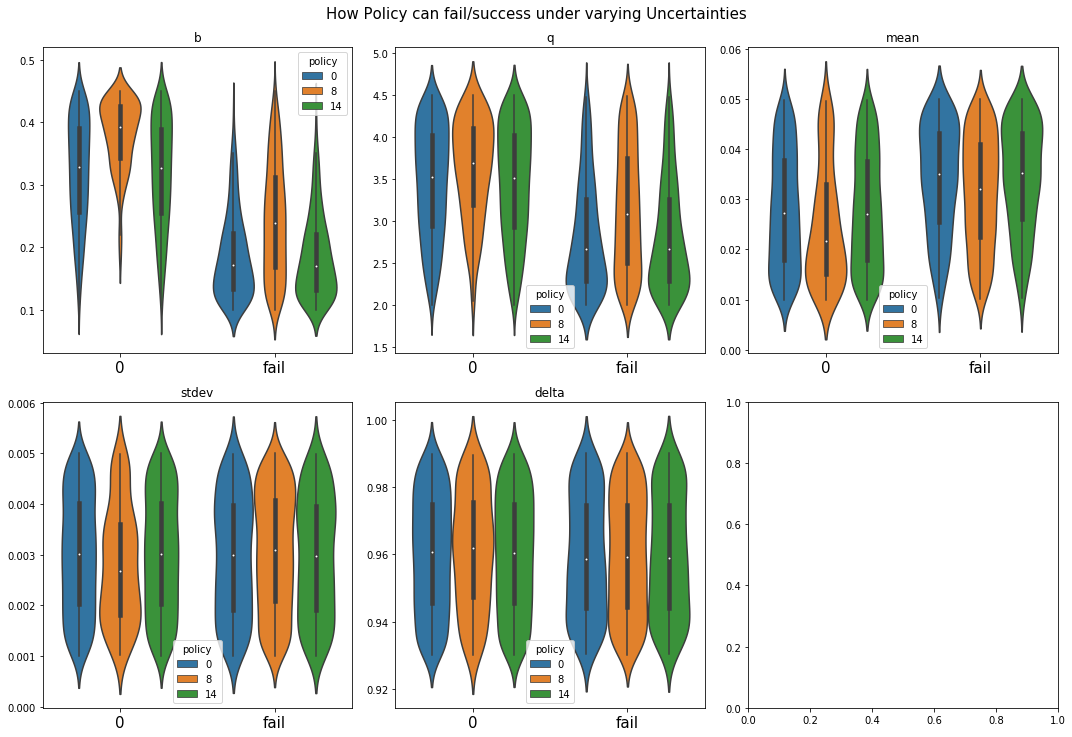

In [19]:
import itertools

ncols=3
nrows=2
fig, axes = plt.subplots(ncols = ncols, nrows = nrows,
#                          sharex = True,
                         figsize = (5*ncols,5*nrows))
locs = list(itertools.product(range(nrows),range(ncols)))

params = list(model.uncertainties.keys())

for i,param in enumerate(params):
    loc=locs[i]
    ax=axes[loc]
    sns.violinplot("fail", param, data = inputs, ax=ax, legend=True,
                   hue="policy"
                  )
    ax.set_xlabel("")
    ax.set_xticklabels(inputs["fail"].unique(),fontsize=15)
    ax.set_ylabel("")
    ax.set_title(param)
fig.tight_layout()
fig.suptitle("How Policy can fail/success under varying Uncertainties", y=1.02, fontsize = 15)

We can now evaluate the **robustness** of each of the policy options based on these scenario results. We can calculate the robustness of a policy option in terms of its performance on an outcome indicator across the 1000 scenarios. In other words, we can identify how robust a policy is in terms of each outcome indicator, and investigate the robustness tradeoffs.  

There are multiple metrics to quantify robustness. On of them is the *signal to noise ratio*, which is simply the mean of a dataset divided by its standard deviation. For instance, for an outcome indicator to be maximized, we prefer a high average value across the scenarios, and a low standard deviation, implying a narrow uncertaintiy range. Therefore, we want to maximize the signal-to-noise ratio. For an outcome indicator to be minimized, a lower mean and a lower standard deviation is preferred. Therefore the formulation shoudl be different.

**Write a function to calculate the signal-to-noise ratio for both kinds of outcome indicators. Calculate the signal-to-noise ratios for each outcome and each policy option. Plot the tradeoffs on a parallel plot. Which solutions look like a good compromise policy?**

In [75]:
outcomes["policy"] = inputs.iloc[:, -3].values

In [80]:
df = np.zeros([len(model.output_variables), outcomes["policy"].nunique()])
df = pd.DataFrame(df, columns=outcomes["policy"].unique(), index=outcomes.columns[:-1])
for i, pol in enumerate(outcomes["policy"].unique()):
    sub_out = outcomes[outcomes["policy"] == pol].iloc[:, :-1]
    func = lambda x: x.mean()/x.std()
    sub_out = func(sub_out)
#     print(sub_out)
    df[pol] = sub_out.values
df = pd.DataFrame(df).T
df

,inertia,max_P,reliability,utility
0,123.178234,0.710437,1.737193,1.317466
8,5.303635,1.372498,0.892749,1.969683
14,119.482967,0.679521,1.941743,0.927552


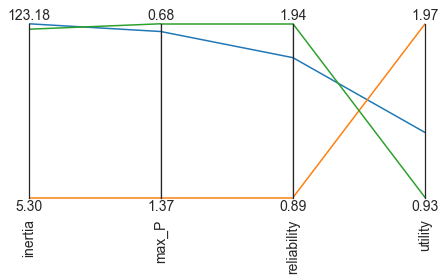

In [87]:
limits = parcoords.get_limits(df)

paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(df)
paraxes.invert_axis('max_P')

Another robustness metric is **maximum regret**, calculated again for each policy and for each outcome indicator. *Regret* is defined for each policy under each scenario, as the difference between the performance of that scenario and the performance of a no-regret or reference policy. The *maximum regret*  is then the maximum of such regret values across all scenarios. We of course favor policy options with low *maximum regret* values. (You can find furter explanation in the slides of the Advanced System Dynamics course.)

**Write a function to calculate the maximum regret for both kinds of outcome indicators. Calculate the maximum regret values for each outcome and each policy option. Plot the tradeoffs on a parallel plot. Which solutions look like a good compromise policy?**

### First Method

In [145]:
ref_performance = outcomes.iloc[0]
ref_performance

inertia            0.99
max_P          0.189161
reliability           1
utility        0.230172
policy                0
Name: 0, dtype: object

In [146]:
outcomes.iloc[1]

inertia            0.99
max_P           0.18118
reliability           1
utility        0.608815
policy                0
Name: 1, dtype: object

In [147]:
ref_performance - outcomes.iloc[1]

inertia                0
max_P          0.0079812
reliability            0
utility        -0.378643
policy                 0
dtype: object

In [155]:
regrets = pd.DataFrame(data=outcomes.apply(lambda x: ref_performance[:-1] - x[:-1], axis =1),
                       columns=outcomes.columns[:-1])
regrets["policy"] = outcomes["policy"]
regrets["max_P"] = regrets["max_P"] * -1
regrets.head()

,inertia,max_P,reliability,utility,policy
0,0.0,-0.000000,0.0,0.000000,0
1,0.0,-0.007981,0.0,-0.378643,0
2,0.0,0.000250,0.0,-0.054173,0
3,0.0,0.022630,0.0,-0.048977,0
4,0.0,-0.010843,0.0,-0.467988,0


In [160]:
regrets = regrets.groupby("policy").sum()
regrets

,inertia,max_P,reliability,utility
policy,,,,
0,5.6093,2183.633212,284.6512,-311.786073
8,106.6431,3838.941600,651.8148,-757.259441
14,5.6603,2087.015205,255.4791,-112.925830


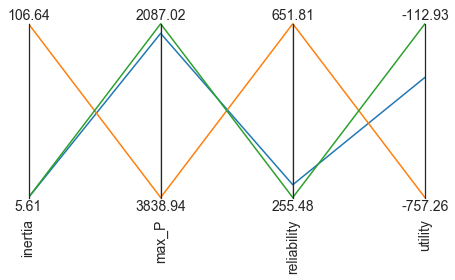

In [159]:
data = regrets
limits = parcoords.get_limits(data)
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis('max_P')

### Second Method

In [162]:
regrets = np.zeros([len(model.output_variables), outcomes["policy"].nunique()])
regrets = pd.DataFrame(regrets, columns=outcomes["policy"].unique(), index=outcomes.columns[:-1])

i = 0
ref_pol = outcomes["policy"].unique()[i]
ref_perform = outcomes[outcomes["policy"] == ref_pol].mean()

for i, pol in enumerate(outcomes["policy"].unique()):
    performance = outcomes[outcomes["policy"] == pol].mean()
#     print(performance)
    regret = ref_perform / performance
#     print(regret["max_P"])
    regret["max_P"] = 1/regret["max_P"]
#     print("REGRET:")
#     print(regret[:-1])
#     print("====================")
    regrets[pol] = regret[:-1].values
regrets

,0,8,14
inertia,1.0,1.114375,1.000052
max_P,1.0,1.697620,0.959281
reliability,1.0,2.054507,0.960818
utility,1.0,0.548856,1.579602


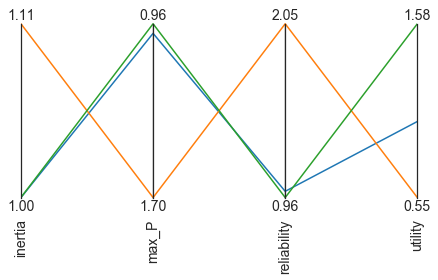

In [163]:
data = regrets.T
limits = parcoords.get_limits(data)
paraxes = parcoords.ParallelAxes(limits)
paraxes.plot(data)
paraxes.invert_axis('max_P')

In [164]:
regrets.loc["SUM"] = regrets.sum(axis=0)
regrets

,0,8,14
inertia,1.0,1.114375,1.000052
max_P,1.0,1.697620,0.959281
reliability,1.0,2.054507,0.960818
utility,1.0,0.548856,1.579602
SUM,4.0,5.415358,4.499753
